In [1]:
import random
import sys
import gc
import re
import time
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from bs4 import BeautifulSoup
from tqdm import tqdm

from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA, SparsePCA, LatentDirichletAllocation, TruncatedSVD # aka LSA
from sklearn.preprocessing import *


from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import * 


from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import BaggingClassifier # will not work for multi-label
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.neighbors import RadiusNeighborsClassifier
from sklearn.tree import ExtraTreeClassifier as ET
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import torch
torch.cuda.is_available()

True

# Start
> See other notebook for preprocessing, we start up loading proprocessed CSVs 

In [2]:
questions = pd.read_csv('./data/questions_preprocessed.csv', index_col=0)
tags = pd.read_csv('./data/tags_preprocessed.csv', index_col=0)
# questions = pd.read_csv('./data/questions_preprocessed_min3.csv', index_col=0)
# tags = pd.read_csv('./data/tags_preprocessed_min3.csv', index_col=0)
questions.head(1)
tags.head(1)

,Formatted
Id,
120,ASP NET Site Maps Has anyone got experience cr...


,Tag
Id,
120,sql


In [ ]:
# questions.loc[40142050].values
# tags.loc[40142050]
# len(X_train)
# X_train[0]

In [4]:
from sklearn.preprocessing import MultiLabelBinarizer
mlb = MultiLabelBinarizer()

list_to_encode = tags.Tag.values
mlb.fit(list_to_encode.reshape(-1,1))

encoded = dict() 
for i in tqdm(tags.index.unique()): 
    input_ = tags.loc[i, 'Tag']
    if (type(input_) is str):
        input_ = np.array(input_)
    else:   
        input_ = input_.values
    
    ouput_ = mlb.transform(input_.reshape(-1,1))
    ouput_ = list(np.sum(ouput_, axis=0))
    encoded[i] = ouput_

MultiLabelBinarizer()

100%|██████████| 498996/498996 [02:02<00:00, 4078.28it/s]


In [5]:
list_of_questions = []
list_of_tags = []
for i in tqdm(questions['Formatted'].index.unique()):
    list_of_questions.append(questions['Formatted'][i])
    list_of_tags.append(encoded[i])

print(f'length is {len(list_of_questions)}')

100%|██████████| 498996/498996 [00:03<00:00, 166277.17it/s]

length is 498996


In [6]:
# some of list_of_questions are nan. Im not sure how to deal with this.
import math
bad_idx = [] # [idx for idx, i in enumerate(list_of_questions) if type(i) is not str if math.isnan(i)]
for idx, i in enumerate(list_of_questions):
    if type(i) is not str:
        if math.isnan(i):
            list_of_questions[idx] = list_of_questions[idx+1]
            list_of_tags[idx] = list_of_tags[idx+1] 

In [7]:
def sizeof_fmt(num, suffix='B'):
    ''' by Fred Cirera,  https://stackoverflow.com/a/1094933/1870254, modified'''
    for unit in ['','Ki','Mi','Gi']:
        if abs(num) < 1024.0:
            return "%3.1f %s%s" % (num, unit, suffix)
        num /= 1024.0
    

for name, size in sorted(((name, sys.getsizeof(value)) for name, value in locals().items()), 
                         key= lambda x: -x[1])[:10]:
    print("{:>30}: {:>8}".format(name, sizeof_fmt(size)))

gc.collect()

                     questions: 539.2 MiB
                          tags: 86.9 MiB
                       encoded: 20.0 MiB
             list_of_questions:  4.0 MiB
                  list_of_tags:  4.0 MiB
                       SCORERS:  2.2 KiB
                          tqdm:  2.0 KiB
                           _i1:  1.7 KiB
                 BeautifulSoup:  1.0 KiB
                           PCA:  1.0 KiB


0

In [8]:
print(f'Sample question: {list_of_questions[0]}\n')
print(f'Number of tags: {sum(list_of_tags[0])}')

Sample question: ASP NET Site Maps Has anyone got experience creating SQL based ASP NET site map providers ve got the default XML file web sitemap working properly with my Menu and SiteMapPath controls but ll need way for the users of my site to create and modify pages dynamically need to tie page viewing permissions into the standard ASP NET membership system as well 

Number of tags: 2


# Experiment 1: Encoding with Tokenizer, padding sequence

In [9]:
X_train, X_test, y_train, y_test = train_test_split(list_of_questions, list_of_tags, test_size=0.2, random_state=42)

y_train = np.asarray(y_train)
for i in range(len(y_train)):
    y_train[i] = np.array(y_train[i])
    
y_test = np.asarray(y_test)
for i in range(len(y_test)):
    y_test[i] = np.array(y_test[i])

In [10]:
# uniqueWords = set() # same seed as list which we cast to set at end
# for q in list_of_questions[:500000]:
#     for word in q.split():
#         uniqueWords.add(word.lower()) 
# 309411 unique words in first 500000 questions
num_words = None

In [11]:
# # ref https://stackabuse.com/python-for-nlp-multi-label-text-classification-with-keras/
tokenizer = Tokenizer(char_level=False, num_words=num_words, filters='!"()*+,-./:;<=>?@[\\]^_`{|}~\t\n') # #$%&
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

vocab_size = len(tokenizer.word_index) + 1
# vocab_size # 309411

We need to get the pad_sequences's max length. perhaps it's wise to chose the median + IQR*1.5, 167.399044579605, 
IQR: 122 | mean: 167.40 | median: 122.0 | upper bound: 167.399044579605


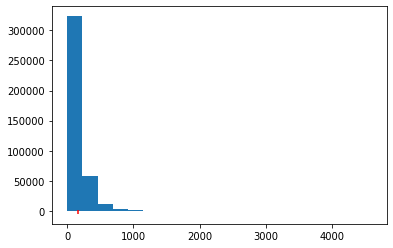

In [12]:
sorted_lengths = np.sort(np.asarray([len(i) for i in X_train]))
IQR = sorted_lengths[3*len(sorted_lengths)//4] - sorted_lengths[1*len(sorted_lengths)//4]
upper_bound = np.mean(sorted_lengths)
# upper_bound = np.median(sorted_lengths) + IQR*1.5

print(f"We need to get the pad_sequences's max length. perhaps it's wise to chose the median + IQR*1.5, {upper_bound}, ")
print(f'IQR: {IQR} | mean: {np.mean(sorted_lengths):.2f} | median: {np.median(sorted_lengths)} | upper bound: {upper_bound}')

_ = plt.hist(sorted_lengths, bins=20)
_ = plt.vlines(upper_bound, -5000, 2000, linestyles='dashed', colors='r', label='Upper Bound')

In [14]:
maxlen = min(int(upper_bound), 200)
X_train = pad_sequences(X_train, padding='post', truncating='post', maxlen=maxlen)
X_test = pad_sequences(X_test,   padding='post', truncating='post', maxlen=maxlen)

In [15]:
# len(tokenizer.word_index.keys())
## dont on `X_train` from test_size=0.99 
# with    lemmatization 35659
# without lemmatization 37851 

print(f'{100*(35659-37851)/37851:.2f}% change in of vocab size with lemmatization on 1 precent of data')

-5.79% change in of vocab size with lemmatization on 1 precent of data


In [16]:
def print_score(y_test, y_pred, clf=None):
    with warnings.catch_warnings():
        # print("Clf: ", clf.__class__.__name__)
        print(f"Accuracy score: {accuracy_score(y_true=y_test, y_pred=y_pred)}")
        print(f"Recall score: {recall_score(y_true=y_test, y_pred=y_pred, average='weighted')}")
        print(f"Precision score: {precision_score(y_true=y_test, y_pred=y_pred, average='weighted')}")
        f1 = f1_score(y_true=y_test, y_pred=y_pred, average='weighted')
        print(f"F1 score: {f1}")
        return f1

## Experiment 1 assessment - sklearn

In [17]:
clfs = []
# clfs.append(DecisionTreeClassifier(random_state=42))
clfs.append(ExtraTreesClassifier(n_estimators=15, random_state=42, n_jobs=-1))
clfs.append(RandomForestClassifier(n_estimators=15, random_state=42, n_jobs=-1))
# clfs.append(RadiusNeighborsClassifier(n_jobs=-1)) # takes a while
# clfs.append(KNeighborsClassifier(n_neighbors=10, n_jobs=-1)) # untested too long

for clf in clfs:
    start = time.time()
    _ = gc.collect()
    _ = clf.fit(X_train, y_train)
    print("Clf: ", clf.__class__.__name__)
    F1 = print_score(y_test, clf.predict(X_test), clf)
    print(f'Train score: {clf.score(X_train, y_train)}')
    print(f'Test score:  {clf.score(X_test, y_test)}')

    print(f'Time taken for {clf.__class__.__name__} was {time.time()-start:.2f}\n\n')
    


Clf:  ExtraTreesClassifier
Accuracy score: 7.014028056112224e-05
Recall score: 9.871059288049849e-05
Precision score: 0.1398204701091986
F1 score: 0.0001972268287894712
Train score: 0.9999899798595177
Test score:  7.014028056112224e-05
Time taken for ExtraTreesClassifier was 242.43


Clf:  RandomForestClassifier
Accuracy score: 0.0010320641282565131
Recall score: 0.0010488000493552964
Precision score: 0.20879851674301186
F1 score: 0.002076166706540318
Train score: 0.879317428030341
Test score:  0.0010320641282565131
Time taken for RandomForestClassifier was 326.77




Clf:  MLPClassifier
Accuracy score: 0.0
Recall score: 0.0
Precision score: 0.0
F1 score: 0.0
Train score: 0.0
Test score:  0.0
Time taken for MLPClassifier was 199.30


<Figure size 576x216 with 0 Axes>

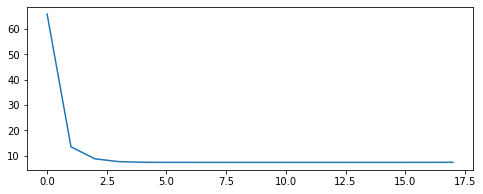

In [18]:
start = time.time()

clf = MLPClassifier(hidden_layer_sizes=(200, 100), random_state=42, max_iter=60)

clf = clf.fit(X_train, y_train)
print("Clf: ", clf.__class__.__name__)
F1 = print_score(y_test, clf.predict(X_test), clf)
print(f'Train score: {clf.score(X_train, y_train)}')
print(f'Test score:  {clf.score(X_test, y_test)}')
    
print(f'Time taken for {clf.__class__.__name__} was {time.time()-start:.2f}')

plt.figure(figsize=(8, 3))
plt.plot(clf.loss_curve_)

### In depth Eval of MLPClassifier, via argmax of `clf.predict_proba`

In [19]:
y_pred = clf.predict_proba(X_test)

y_pred_same_number_of_tags = [] # if average tags is 2.5, we are at a disadvantage if we do 2 or 3 tags.
for i in range(len(y_pred)):  
    best = y_pred[i].argsort()
    y_pred_ = np.zeros(y_pred.shape[1])
    number_of_tags = np.sum(y_test[i])
    y_pred_[best[-number_of_tags:]] = 1
    y_pred_same_number_of_tags.append(y_pred_)
    
_ = print_score(y_test, y_pred_same_number_of_tags) 
print("")

for i in range(5): # how many examples to print
    idx = np.random.randint(0, len(y_pred))
    print("y_pred:",', '.join(mlb.inverse_transform(y_pred_same_number_of_tags[idx].reshape(1,-1))[0]))
    print("y_test:",', '.join(mlb.inverse_transform(y_test[idx].reshape(1,-1))[0]))
    print('\n')

Accuracy score: 0.05029058116232465
Recall score: 0.129113455487692
Precision score: 0.0484842678766208
F1 score: 0.048090358807756674

y_pred: java
y_test: java


y_pred: c#, java
y_test: java, swing


y_pred: c#, java
y_test: html5, javascript


y_pred: c#, java
y_test: mysql, php


y_pred: java
y_test: spring




In [20]:
## Dim reduction was pointless

# print(f'shape of X_train: {X_train.shape}')

# # from sklearn.decomposition import LatentDirichletAllocation # took ovr 10 mins
# # dcomp = LatentDirichletAllocation(n_components=100, random_state=42)

# dcomp = PCA(n_components=100, random_state=42) # , iterated_power=30
# dcomp.fit(X_train)
# print(f'explained variance ratio: {sum(dcomp.explained_variance_ratio_):.2f}')
# X_train_transformed = dcomp.transform(X_train)
# X_test_transformed = dcomp.transform(X_test)

# print(f'shape of X_train_transformed: {X_train_transformed.shape}')

# start = time.time()

# clf = MLPClassifier(random_state=42, max_iter=140)
# clf = clf.fit(X_train_transformed, y_train)
# print("Clf: ", clf.__class__.__name__)

# print_score(y_test, clf.predict(X_test_transformed), clf)
# print(f'Train score: {clf.score(X_train_transformed, y_train)}')
# print(f'Test score:  {clf.score(X_test_transformed, y_test)}')
    
# print(f'Time taken for {clf.__class__.__name__} was {time.time()-start:.2f}')

## Experiment 1 assessment - Basic LSTM

In [21]:
vocab_size = len(tokenizer.word_index) + 1
target_size = len(mlb.classes_)
embedding_dim = 300

In [41]:
## Build glove embdedding matrix
embeddings_dictionary = dict()
# glove_file = open('.\data\glove.42B.300d.txt', encoding="utf8")
glove_file = open('C:\\glove.42B.300d.txt', encoding="utf8")
for line in glove_file: # longer, by far
    records = line.split()
    word = records[0]
    vector_dimensions = np.asarray(records[1:], dtype='float32')
    embeddings_dictionary[word] = vector_dimensions
glove_file.close()

num_words_in_embedding = 0
# embedding_matrix = np.zeros((vocab_size, embedding_dim))
embedding_matrix = np.random.normal(scale=0.6, size=((vocab_size, embedding_dim)))
for word, index in tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        num_words_in_embedding += 1
        embedding_matrix[index] = embedding_vector
        
print(f'portion of words in embedding: {num_words_in_embedding/vocab_size:.4f}')

portion of words in embedding: 0.2708


In [78]:
import tensorflow.keras as keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from keras.layers.embeddings import Embedding
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.layers import Input
# del model, opt, lr

loss = []
acc = []
val_loss = []
val_acc = []
checkpoint_file = 'ModelCheckpoint.h5'


In [79]:
output_dim = mlb.classes_.shape[0]
model = Sequential() ;_=gc.collect()
model.add(Embedding(vocab_size, embedding_dim, weights=[embedding_matrix], input_length=maxlen, trainable=False))
model.add((Bidirectional(LSTM(64, return_sequences=True))))
model.add(Dropout(0.05)) # technically not appropriate for a LSTM. recc_dropout is not on CuDNN
model.add(LSTM(128))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2)) 
model.add(Dense(output_dim, activation='sigmoid')) # , activation='softmax')

opt = Adam(learning_rate=0.003)

model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['acc']) # categorical_crossentropy
lr = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=2, verbose=1, mode='auto', min_delta=0.0001, cooldown=0, min_lr=0.00001)
cp = ModelCheckpoint(filepath=checkpoint_file, monitor='val_acc', save_best_only=True)

In [80]:
# model = keras.models.load_model("keras_lstm.h5")
# model.layers[0].trainable = True
history = model.fit(X_train, y_train, validation_split=0.05, epochs=10, batch_size=256, verbose=1, callbacks=[lr, cp])
loss.extend(history.history['loss'])
acc.extend(history.history['acc'])
val_loss.extend(history.history['val_loss'])
val_acc.extend(history.history['val_acc'])

Epoch 1/20
476/476 [==============================] - 25s 44ms/step - loss: 0.0814 - acc: 0.0678 - val_loss: 0.0728 - val_acc: 0.0773 - lr: 0.0030
Epoch 2/20
476/476 [==============================] - 19s 40ms/step - loss: 0.0719 - acc: 0.0869 - val_loss: 0.0667 - val_acc: 0.1552 - lr: 0.0030
Epoch 3/20
476/476 [==============================] - 20s 41ms/step - loss: 0.0569 - acc: 0.2938 - val_loss: 0.0452 - val_acc: 0.4245 - lr: 0.0030
Epoch 4/20
476/476 [==============================] - 19s 41ms/step - loss: 0.0416 - acc: 0.4828 - val_loss: 0.0369 - val_acc: 0.5135 - lr: 0.0030
Epoch 5/20
476/476 [==============================] - 20s 42ms/step - loss: 0.0352 - acc: 0.5484 - val_loss: 0.0326 - val_acc: 0.5550 - lr: 0.0030
Epoch 6/20
476/476 [==============================] - 19s 40ms/step - loss: 0.0318 - acc: 0.5770 - val_loss: 0.0309 - val_acc: 0.5613 - lr: 0.0030
Epoch 7/20
476/476 [==============================] - 20s 41ms/step - loss: 0.0298 - acc: 0.5921 - val_loss: 0.0302 - 

In [81]:
# model.save("keras_lstm_min_3_score.h5" )
# model.save("keras_lstm_all_scores.h5" )

In [82]:
def test_keras_model(print_sample=False, X_test=X_test, model=model, y_test=y_test, topN=2):
    # y_pred = model.predict(X_test)
    # for thres in range(3, 5):
    #     print(f'rounding threshold: {thres/10}')
    #     y_pred_ = np.array(np.array(y_pred) > thres/10, dtype=float)
    #     _ = print_score(y_test, y_pred_)
        # print('\n')


    ## y_pred = np.array(np.array(y_pred) > .3, dtype=float)
    # topN = topN
    # y_pred_top = np.zeros_like(y_pred)
    # for i in range(y_pred.shape[0]):
    #     best = y_pred[i].argsort()
    #     y_pred_ = np.zeros(y_pred.shape[1])
    #     y_pred_[best[-topN:]] = 1
    #     y_pred_top[i] = y_pred_

    # print(f'\ntopN: {topN}')
    # _ = print_score(y_test, y_pred_top)
    
    y_pred_same_number_of_tags = [] # if average tags is 2.5, we are at a disadvantage if we do 2 or 3 tags.
    
    for i in range(len(y_pred)):  
        best = y_pred[i].argsort()
        y_pred_ = np.zeros(y_pred.shape[1])
        number_of_tags = np.sum(y_test[i])
        y_pred_[best[-number_of_tags:]] = 1
        y_pred_same_number_of_tags.append(y_pred_)
        
    _ = print_score(y_test, y_pred_same_number_of_tags) 

    # if print_sample:
    for i in range(print_sample):
        idx = np.random.randint(0, len(y_pred))
        print("y_pred:",', '.join(mlb.inverse_transform(y_pred_same_number_of_tags[idx].reshape(1,-1))[0]))
        print("y_test:",', '.join(mlb.inverse_transform(y_test[idx].reshape(1,-1))[0]))
        print('\n')

test_keras_model(print_sample=0)

Accuracy score: 0.6018110850897737
Recall score: 0.7138925218138163
Precision score: 0.709068864522389
F1 score: 0.7091016493667925


In [84]:
_=gc.collect()
model.layers[0].trainable = True
history = model.fit(X_train, y_train, validation_split=0.05, epochs=5, batch_size=256, verbose=1, callbacks=[lr, cp])
# model.save("keras_lstm_min_3_score.h5")

loss.extend(history.history['loss'])
acc.extend(history.history['acc'])
val_loss.extend(history.history['val_loss'])
val_acc.extend(history.history['val_acc'])

Epoch 1/4
476/476 [==============================] - 17s 34ms/step - loss: 0.0203 - acc: 0.6657 - val_loss: 0.0302 - val_acc: 0.5792 - lr: 2.4300e-05
Epoch 2/4
476/476 [==============================] - 16s 34ms/step - loss: 0.0203 - acc: 0.6666 - val_loss: 0.0303 - val_acc: 0.5786 - lr: 2.4300e-05
Epoch 3/4
476/476 [==============================] - ETA: 0s - loss: 0.0203 - acc: 0.6660
Epoch 00003: ReduceLROnPlateau reducing learning rate to 1e-05.
476/476 [==============================] - 16s 34ms/step - loss: 0.0203 - acc: 0.6660 - val_loss: 0.0303 - val_acc: 0.5786 - lr: 2.4300e-05
Epoch 4/4
476/476 [==============================] - 16s 34ms/step - loss: 0.0203 - acc: 0.6675 - val_loss: 0.0303 - val_acc: 0.5785 - lr: 1.0000e-05


In [85]:
# decrease LR and batch size
_=gc.collect()
keras.backend.set_value(model.optimizer.lr, 0.0005)
model.layers[0].trainable = True
history = model.fit(X_train, y_train, validation_split=0.05, epochs=5, batch_size=64, verbose=1, callbacks=[lr, cp])
model.save("keras_lstm_min_3_score.h5")

loss.extend(history.history['loss'])
acc.extend(history.history['acc'])
val_loss.extend(history.history['val_loss'])
val_acc.extend(history.history['val_acc'])

Epoch 1/5
1902/1902 [==============================] - 48s 25ms/step - loss: 0.0214 - acc: 0.6572 - val_loss: 0.0301 - val_acc: 0.5761 - lr: 5.0000e-04
Epoch 2/5
1902/1902 [==============================] - 49s 26ms/step - loss: 0.0209 - acc: 0.6605 - val_loss: 0.0304 - val_acc: 0.5744 - lr: 5.0000e-04
Epoch 3/5
1902/1902 [==============================] - ETA: 0s - loss: 0.0205 - acc: 0.6649
Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.0001500000071246177.
1902/1902 [==============================] - 50s 26ms/step - loss: 0.0205 - acc: 0.6649 - val_loss: 0.0309 - val_acc: 0.5738 - lr: 5.0000e-04
Epoch 4/5
1902/1902 [==============================] - 48s 25ms/step - loss: 0.0197 - acc: 0.6699 - val_loss: 0.0312 - val_acc: 0.5741 - lr: 1.5000e-04
Epoch 5/5
1900/1902 [============================>.] - ETA: 0s - loss: 0.0195 - acc: 0.6716
Epoch 00005: ReduceLROnPlateau reducing learning rate to 4.500000213738531e-05.
1902/1902 [==============================] - 47s 25ms/step

#### This will print the top five most likely tags, and then the 4 metrics, in a manner such the the network preds the same number of tags as the ground truth

In [88]:
model.load_weights(checkpoint_file)

y_pred = model.predict(X_test)

topN = 5
y_pred_top = np.zeros_like(y_pred)
for i in range(y_pred.shape[0]):
    best = y_pred[i].argsort()
    y_pred_ = np.zeros(y_pred.shape[1])
    y_pred_[best[-topN:]] = 1
    y_pred_top[i] = y_pred_

for i in range(5): # how many examples to print
    idx = np.random.randint(0, len(y_pred))
    print("y_pred:",', '.join(mlb.inverse_transform(y_pred_top[idx].reshape(1,-1))[0]))
    print("y_test:",', '.join(mlb.inverse_transform(y_test[idx].reshape(1,-1))[0]))
    print('\n')
    

y_pred_same_number_of_tags = [] # if average tags is 2.5, we are at a disadvantage if we do 2 or 3 tags.
for i in range(len(y_pred)):  
    best = y_pred[i].argsort()
    y_pred_ = np.zeros(y_pred.shape[1])
    number_of_tags = np.sum(y_test[i])
    y_pred_[best[-number_of_tags:]] = 1
    y_pred_same_number_of_tags.append(y_pred_)
    
_ = print_score(y_test, y_pred_same_number_of_tags) 

y_pred: c, c++, debugging, gcc, linux
y_test: c, gcc


y_pred: ios, iphone, objective-c, swift, xcode
y_test: ios, xcode


y_pred: android, image, java, security, xml
y_test: android


y_pred: .net, c#, c++, java, oop
y_test: java, oop


y_pred: android, eclipse, image, java, xml
y_test: android


Accuracy score: 0.6074004683840749
Recall score: 0.7184016865447306
Precision score: 0.7106922187288004
F1 score: 0.7064893569114334


```
on the all scores dataset "questions_preprocessed.csv"
2963/2963 [==============================] - 85s 29ms/step - loss: 0.0199 - acc: 0.6533 - val_loss: 0.0242 - val_acc: 0.6135 - lr: 5.0000e-04

Accuracy score: 0.6504909819639279
Recall score: 0.7615028687766056
Precision score: 0.7574494222705919
F1 score: 0.7544918807953225


on the min 3 scores dataset "questions_preprocessed_min3.csv"

1902/1902 [==============================] - 47s 25ms/step - loss: 0.0195 - acc: 0.6716 - val_loss: 0.0313 - val_acc: 0.5739 - lr: 1.5000e-04

Accuracy score: 0.6123965651834504
Recall score: 0.7221690839173125
Precision score: 0.7139613396235852
F1 score: 0.714711189087093


```

<Figure size 864x576 with 0 Axes>

Text(0.5, 1.0, 'LSTM w/ GloVe Loss BCE')

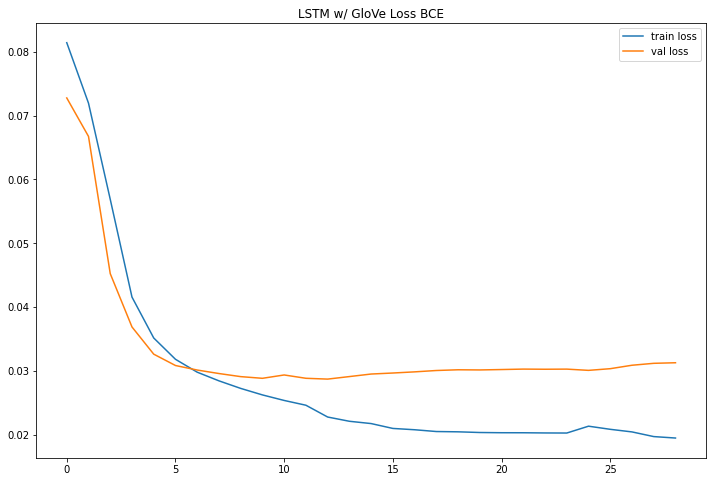

In [91]:
plt.figure(figsize=(12,8))
plt.title('LSTM w/ GloVe Loss BCE')
plt.plot(loss, label='train loss')
plt.plot(val_loss, label='val loss')
plt.legend()
plt.show()

### The torch model failed to train
> code is left to show proof of work

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
# def minimal_code_example():
#     m = nn.Sigmoid()
#     loss = nn.BCELoss()

#     input = torch.randn(3, requires_grad=True)
#     target = torch.empty(3).random_(2)

#     lin = torch.nn.Linear(3,3)
#     optimizer = optim.SGD(lin.parameters(), lr = 0.001)

#     print(f'lin(input)    = {lin(input).detach().numpy()}')
#     print(f'target        = {target.detach().numpy()}')
    
#     for i in range(500):
#         output = loss(m(lin(input)), target)
#         # optimizer.clear_grad()
#         output.backward()
#         optimizer.step()
#         # output.item()

#     print(f'lin(input)    = {lin(input).detach().numpy()}')
#     print(f'm(lin(input)) = {m(lin(input)).detach().numpy()}')
#     print(f'target        = {target.detach().numpy()}')
    

# minimal_code_example()

In [ ]:
X_train_tensor = torch.tensor(X_train).to(device)
X_test_tensor = torch.tensor(X_test).to(device)

y_train_tensor = torch.tensor(y_train, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).to(device)

embedding_matrix = torch.tensor(embedding_matrix)
(vocab_size, embedding_dim)

# idx = 64
# X_train_tensor, X_test_tensor, y_train_tensor, y_test_tensor = X_train_tensor[:idx], X_test_tensor[:idx], y_train_tensor[:idx], y_test_tensor[:idx]


In [ ]:
# from my past code https://github.com/alik604/cyber-security/blob/master/Intrusion-Detection/UNSW_NB15%20-%20PyTorch%20feature%20selection%20via%20L1%20regularization%20on%20layer_1.ipynb
class LSTM(nn.Module):

    def __init__(self, vocab_size, embedding_dim, target_size):
        super(LSTM, self).__init__()
        self.embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim*maxlen, target_size)
        self.linear = nn.Linear(target_size, target_size)
        self.linear_out = nn.Linear(target_size, target_size)
        
        self.embeddings.load_state_dict({'weight': embedding_matrix})
        # self.embeddings.weight.requires_grad = False


    def forward(self, inputs):
        # print(f'inputs: {inputs.size()}')
        
        out = self.embeddings(inputs) 
        # print(f'embeds: {out.size()}')
        
        out, _ = self.lstm(out.view(len(inputs), 1, -1))
        # print(f'lstm: {out.size()}')
        
        out = out.view(len(inputs), -1)
        out = F.relu(self.linear(out))
        # print(f'linear: {out.size()}')
        
        out = self.linear_out(out)
        # print(f'linear_out: {out.size()}')
        
        return F.sigmoid(out)

In [ ]:
num_epochs = 0 # 10 # disable. model will not train
batch_size = 128
batch_size_test = 512
LR = 0.0005 # 0.001

train_losses = []
test_losses = []
best_f1 = -1

criterion = nn.BCELoss() # nn.CrossEntropyLoss()
model = LSTM(vocab_size, embedding_dim, target_size).to(device)
try:
    model.load_state_dict(torch.load('model.pt'))
except:
    print('model.pt not found')
optimizer = optim.Adam(model.parameters(), lr=LR)

In [ ]:

for epoch in range(num_epochs):
    train_loss = 0
    test_loss = 0
    
    if epoch == int(num_epochs/2):
        model.embeddings.weight.requires_grad = True
        
    for i in range(0, X_train_tensor.shape[0], batch_size):

        x = X_train_tensor[i:i+batch_size]#.to(device)
        y = y_train_tensor[i:i+batch_size]#.to(device)

        optimizer.zero_grad()
        outputs = model(x)     
        
        # print(f'outputs: {outputs.size()} | {y.dtype}')
        # print(f'y:       {y.size()} | {y.dtype}')        
        # print(outputs[0])
        # print(y[0])
        # break
        loss = criterion(outputs, y)
        
        round_ = torch.round(outputs)
        number_of_predictions_per_sample = torch.sum(round_, -1)
        number_of_predictions_per_batch = torch.sum(number_of_predictions_per_sample > 1)
        if  number_of_predictions_per_batch < batch_size: # there must be a pred for each sample, the network thinks it can preform by marely guessing all 0s
            loss = loss + (batch_size - number_of_predictions_per_batch)/batch_size  # 0.01 * torch.norm(model.embeddings.weight, 1) 
            
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        # break
    train_losses.append(train_loss)

    if epoch % 1 == 0:
        l = X_test_tensor.shape[0]
        y_pred = np.zeros((l, target_size))
        for i in range(0, l, batch_size_test):
            with torch.no_grad(): 
                x = X_test_tensor[i:i+batch_size_test]#.to(device)
                y = y_test_tensor[i:i+batch_size_test]#.to(device)
                
                outputs = model(x)
                y_pred[i:min(i+batch_size_test, l)] = outputs.detach().cpu().numpy()  
                loss = criterion(outputs, y) 
                test_loss += loss.item()
                
        test_losses.append(test_loss)
        y_pred = np.array(y_pred > 0.5, dtype=float) # TODO if this was used, there is better code for this used with the keras model
        
        print(f'[{epoch+1}/{num_epochs}] | Train Loss {train_loss/len(X_train_tensor):.6f} | Test Loss {test_loss/len(X_test_tensor):.6f}')
        
        f1 = print_score(y_test_tensor.detach().cpu().numpy(), y_pred)
        if f1 > best_f1:
            best_f1 = f1
            torch.save(model.state_dict(), 'model.pt')
            print('\tWeights Saved')
    else:
        print(f'[{epoch+1}/{num_epochs}] | Train Loss {train_loss/len(X_train_tensor):.6f}')



In [ ]:
torch.cuda.empty_cache()
gc.collect()
# del X_train_tensor, X_test_tensor, y_train_tensor, y_test_tensor, model, optimizer, criterion

# plt.plot(train_losses)

In [ ]:
def predict(X):
    # y_pred_ = []
    y_pred_ = np.zeros((X.shape[0], 101))
    with torch.no_grad(): 
        for i in range(0, X.shape[0], 512):
            with torch.no_grad(): 
                x = X[i:i+512].to(device)
                y_pred = model(x).detach().cpu().numpy()      
                y_pred_[i:min(i+512, X.shape[0])] = y_pred #.extend(x)
    return y_pred_

sample = 64
y_pred = predict(X_test_tensor[:sample])
y_pred = np.array(np.array(y_pred) > 0.5, dtype=float)
print_score(y_test[:sample], y_pred[:sample])

# Expirement 2: Encoding with TfidfVectorizer
> the following stats are for the `tags_preprocessed.csv` dataset

In [28]:
# https://www.linkedin.com/pulse/count-vectorizers-vs-tfidf-natural-language-processing-sheel-saket
# https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html
# https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html

# Equivalent to CountVectorizer followed by TfidfTransformer.
# would be cool to try tri-grams. 
stop_words = "english"
stop_words = None # there are maybe 300 stop words, and thousands of other features. i'm inclined to keep them around
max_features = 374513 # 374513 for unigrams without min_df
max_features = 5000  # realistic? 
min_df=5   # 108967 
min_df=50  # 20671
min_df=200 # 8908
min_df=1000# 3385
max_df=0.90 # 8908 -> 8906
# max_df=0.85 # 8906 -> 8906


### if on tags_preprocessed_min3.csv dataset, use this
min_df=318 # 3378


vectorizer = TfidfVectorizer(strip_accents='unicode', ngram_range=(1, 1), stop_words=stop_words, max_features=max_features, min_df=min_df, max_df=max_df)
# vectorizer = CountVectorizer()

docs       = vectorizer.fit_transform(list_of_questions)
features   = vectorizer.get_feature_names()
print(f'The number of features is {len(features)}')

The number of features is 5000


In [29]:
# rand = random.randint(0, len(features)-10)
# features[rand: rand+10]

### Note the `test_size` below

In [30]:
print(f'The number of samples is {docs.shape[0]} \nThe number of features is {docs.shape[1]}')

X_train, X_test, y_train, y_test = train_test_split(docs, list_of_tags, test_size=0.2, random_state=42)

y_train = np.asarray(y_train)
for i in range(len(y_train)):
    y_train[i] = np.array(y_train[i])
    
y_test = np.asarray(y_test)
for i in range(len(y_test)):
    y_test[i] = np.array(y_test[i])

The number of samples is 498996 
The number of features is 5000


In [31]:
# print(f'shape of X_train: {X_train.shape}')

# # dcomp = SparsePCA(n_components=200, max_iter=1, n_jobs=-1, random_state=42) # poor performance 
# dcomp = TruncatedSVD(n_components=1500, n_iter=20, random_state=42) # 

# dcomp.fit(X_train.toarray())
# print(f'explained variance ratio: {sum(dcomp.explained_variance_ratio_):.2f}')
# X_train_transformed = dcomp.transform(X_train.toarray())
# X_test_transformed = dcomp.transform(X_test.toarray())
# print(f'shape of X_train_transformed: {X_train_transformed.shape}')

In [32]:
### TruncatedSVD()
## n_components=300
# 3  itr gave explained variance ratio: 0.41
# 15 itr gave explained variance ratio: 0.42

## n_components=500
# 3  itr gave explained variance ratio: 0.53
# 15 itr gave explained variance ratio: 0.53

## n_components=1000
# 3  itr gave explained variance ratio: 0.71
# 15 itr gave explained variance ratio: 0.71

## n_components=1500
# 3  itr gave explained variance ratio: 0.82


# clfs = []
# # clfs.append(DecisionTreeClassifier(random_state=42))
# clfs.append(ExtraTreesClassifier(n_estimators=10, random_state=42, n_jobs=-1))
# clfs.append(RandomForestClassifier(n_estimators=15, random_state=42, n_jobs=-1))
# # clfs.append(RadiusNeighborsClassifier(n_jobs=-1))

# # clfs.append(KNeighborsClassifier(n_neighbors=10, n_jobs=-1)) # untested

# for clf in clfs:
#     start = time.time()
    
#     _ = clf.fit(X_train_transformed, y_train)
    
#     print("Clf: ", clf.__class__.__name__)
#     print_score(y_test, clf.predict(X_test_transformed))
#     print(f'Train score: {clf.score(X_train_transformed, y_train)}')
#     print(f'Test score:  {clf.score(X_test_transformed, y_test)}')

#     print(f'Time taken for {clf.__class__.__name__} was {time.time()-start:.2f}\n\n')


# min score 1... min df 1000

In [33]:
clfs = []
# clfs.append(DecisionTreeClassifier(random_state=42))
clfs.append(ExtraTreesClassifier(n_estimators=10, random_state=42, n_jobs=3))
clfs.append(RandomForestClassifier(n_estimators=15, random_state=42, n_jobs=3))
# clfs.append(RadiusNeighborsClassifier(n_jobs=-1))

# clfs.append(KNeighborsClassifier(n_neighbors=10, n_jobs=-1)) # untested

for clf in clfs:
    start = time.time()
    _ = gc.collect()
    _ = clf.fit(X_train, y_train)
    
    print("Clf: ", clf.__class__.__name__)
    f1 = print_score(y_test, clf.predict(X_test))
    print(f'Train score: {clf.score(X_train, y_train)}')
    print(f'Test score:  {clf.score(X_test, y_test)}')

    print(f'Time taken for {clf.__class__.__name__} was {time.time()-start:.2f}\n\n')

Clf:  MLPClassifier
Accuracy score: 0.33423887587822015
Recall score: 0.5944094165414121
Precision score: 0.6495997459270161
F1 score: 0.6191668671471201
Train score: 0.9959952536339365
Test score:  0.33423887587822015
Time taken for MLPClassifier was 1801.59


<Figure size 432x216 with 0 Axes>

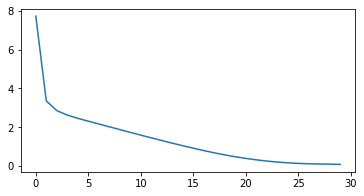

In [103]:
print('Caution MLPClassifier can take long to train. ')
start = time.time()

clf = MLPClassifier(hidden_layer_sizes=(512, 100), random_state=42, max_iter=30)

clf = clf.fit(X_train, y_train)

print("Clf: ", clf.__class__.__name__)
f1 = print_score(y_test, clf.predict(X_test))
print(f'Train score: {clf.score(X_train, y_train)}')
print(f'Test score:  {clf.score(X_test, y_test)}')
    
print(f'Time taken for {clf.__class__.__name__} was {time.time()-start:.2f}')

plt.figure(figsize=(6,3))
plt.plot(clf.loss_curve_)

In [102]:
del clfs
_=gc.collect()

72

In [ ]:
y_pred = clf.predict(X_test[:])
for i in range(5):
    idx = np.random.randint(0, len(y_pred))
    print("y_pred:",', '.join(mlb.inverse_transform(y_pred[idx].reshape(1,-1))[0]))
    print("y_test:",', '.join(mlb.inverse_transform(y_test[idx].reshape(1,-1))[0]))
    print('\n')


y_pred: c#
y_test: c#


y_pred: 
y_test: xml


y_pred: 
y_test: class


y_pred: ios, objective-c
y_test: ios, objective-c


y_pred: django, python
y_test: django


y_pred: 
y_test: c++


y_pred: c#, delphi, winforms
y_test: .net, c#, winforms


y_pred: android
y_test: android


y_pred: database, mysql
y_test: database, mysql


y_pred: ipad
y_test: iphone, objective-c, xcode




In [ ]:
y_pred_same_number_of_tags = [] # if average tags is 2.5, we are at a disadvantage if we do 2 or 3 tags.
for i in range(len(y_pred)):  
    best = y_pred[i].argsort()
    y_pred_ = np.zeros(y_pred.shape[1])
    number_of_tags = np.sum(y_test[i])
    y_pred_[best[-number_of_tags:]] = 1
    y_pred_same_number_of_tags.append(y_pred_)
    
_ = print_score(y_test, y_pred_same_number_of_tags) 

Accuracy score: 0.41033567525370807
Recall score: 0.5303246208202386
Precision score: 0.6853284607898511
F1 score: 0.585585014891463


In [ ]:
# without ensuring the same number of tags, we are at a disadvantage if we do 2 or 3 tags.

print("Train set")
_ = print_score(y_train, clf.predict(X_train)) 

print("Test set")
_ = print_score(y_test, y_pred) 

Train set
Accuracy score: 0.9959952536339365
Recall score: 0.9989239633364962
Precision score: 0.998521101023201
F1 score: 0.9987211981852843
Test set
Accuracy score: 0.33423887587822015
Recall score: 0.5944094165414121
Precision score: 0.6495997459270161
F1 score: 0.6191668671471201


## Miscellaneous ending statistics and investigation 
> out of order execution. note TF-IDF will discrd data. y_train for it can not be assumed to be similar to y_train from tokenizer

In [57]:
df = pd.DataFrame(np.concatenate((y_train, y_test)), index=None)
# df

,0,1,2,3,4,5,6,7,8,9,...,91,92,93,94,95,96,97,98,99,100
0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
498991,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
498992,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
498993,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
498994,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [98]:
# df.apply(pd.value_counts)

value_counts = df.value_counts()[0].index
for i in range(3):
    tmp = value_counts[i]
    tmp = np.array(tmp)
    tmp = np.concatenate((np.array([0]), tmp))
    mlb.inverse_transform(tmp.reshape(1,-1))[0][0]
    
    y_pred = np.zeros_like(y_test)
    for i in y_pred:
        y_pred[i] = tmp
    F1=print_score(y_test, y_pred)

'android'

Accuracy score: 0.0
Recall score: 0.0
Precision score: 0.0
F1 score: 0.0


'java'

Accuracy score: 0.0
Recall score: 0.0
Precision score: 0.0
F1 score: 0.0


'python'

Accuracy score: 0.0
Recall score: 0.0
Precision score: 0.0
F1 score: 0.0


In [96]:
top = tags.value_counts()[:3]
# print(top)
top = mlb.transform(top.index)

ii=0
for i in top: 
    print(f'\nnext is {tags.value_counts()[:3].index[ii][0]}')
    y_pred = np.zeros_like(y_test)
    for i in y_pred:
        y_pred[i] = top[i]
    F1=print_score(y_test, y_pred)
    ii=ii+1

Tag       
java          53895
javascript    52490
c#            51597
dtype: int64


next is java
Accuracy score: 0.0
Recall score: 0.0
Precision score: 0.0
F1 score: 0.0


0.0


next is javascript
Accuracy score: 0.0
Recall score: 0.0
Precision score: 0.0
F1 score: 0.0


0.0


next is c#
Accuracy score: 0.0
Recall score: 0.0
Precision score: 0.0
F1 score: 0.0


0.0

In [ ]:
# uniqueWords = [] 
# for q in list_of_questions[:1000]:
#     for word in q.split():
#       if not word in uniqueWords:
#           uniqueWords.append(word);
          
# len(uniqueWords)